# Backtesting machine learning trading algorithmns 

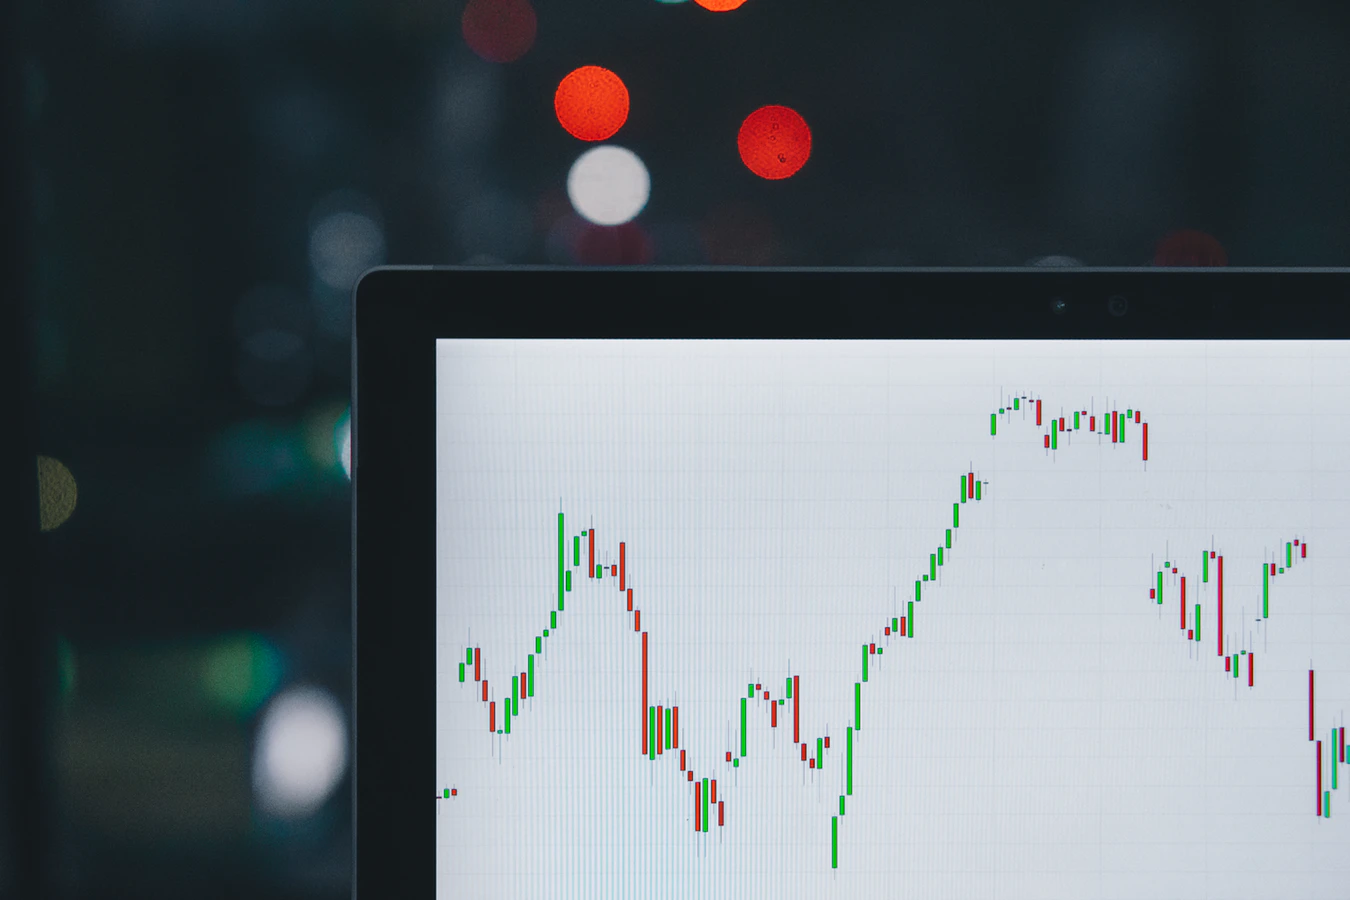

In this Notebook I will go through how to build a machine learning work flow for analysing a certain trading startegies on the UK100 index. The strategy will be looking at the previous 10 days, daily price movement, to see if they are indictative at all as to what todays price movement direction will be. E.G if we have had 10 heavy downwards movements over the last 5 days would that make it more likely that we will seen a price movement upwards (mean reversion) etc.

The lagged returns will act as our "features" and the actual price movement directions will be our "labels" (output variable). Because our labels only have a (-1 or +1) output this is a classification problem as the label variable is not continous.

# 1. Firstly we need to connect to the FXCM API to be able to download historical data 

I have a demo broking account with FXCM which gives me access to the FXCM API where I can download tick data and it also allows to subscribe to it in real time for when you are ready for implementing our trading strategy

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import fxcmpy
import seaborn as sns
from datetime import datetime
import random 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, balanced_accuracy_score

# the API come with a class called fxcmpy for interacting with it

api = fxcmpy.fxcmpy(config_file="fxcm.cfg")

from fxcmpy import fxcmpy_tick_data_reader as tdr 

print(tdr.get_available_symbols())


# we want to set a random seed so that our results are reporduceable
np.random.seed(42)

('AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'CADCHF', 'EURAUD', 'EURCHF', 'EURGBP', 'EURJPY', 'EURUSD', 'GBPCHF', 'GBPJPY', 'GBPNZD', 'GBPUSD', 'GBPCHF', 'GBPJPY', 'GBPNZD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY')


## 2. We need to set all of the parameters in with which we want to test our algorithm

We are going to test a variety of well known machine learning algorithmns to see which performs best with our lagged indicator strategy. And by best I mean decipher which has the most predictive power.

We are going to look at: the support vector machine and the K nearest neighbours alogiriths

Machine learning algorithmns need to be tuned to find the best parameters for working with different types of data. Therefore here we set up the hyperparamter space over which we will want the algorithmn to iterate through to find the most predictive parameters when fitting to the data, we set the "acccuracy score" as the metric for deciding predictive power.

In [8]:
""" ------------------ MODEL INPUTS!!! -------------------------------"""

""" set data paramters """

index_totrade = "UK100"
candle_size = "D1"
PreviousCandles = 10000

""" set ML paramters """

lags_list = [10]

from sklearn.svm import SVC
SupportVec = SVC()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

cross_vals = 3
models_to_fit = [knn]
model_names = ['knn']

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid_SVC =  parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

#logreg param space
c_space = np.logspace(-5, 8, 15)
param_grid_logreg = {'C': c_space}

#knn param spzce
leaf_size = list(np.arange(1,41,10))
n_neighbors = list(np.arange(1,21,5))
p=[1,2]
param_grid_knn = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

parameter_grids = [param_grid_knn]

refit_score = 'accuracy_score'


""" set trading algorithmn parameters """

Total_Balance = 1000
Risk_perTrade = 0.01
financing_cost = 0.0001
stoploss = 0.9

# 3 Download the UK100 data and visualise it

It is always best to do exploratory data analysis on any raw data so we will down load the data and make sure it looks as we expect. We will also append variables that will come in use that don't come with the data such as creating the daily returns and working out the maximum daily movements in case we want to implement a stop loss strategy

In [10]:
data = api.get_candles(index_totrade, period=candle_size,number=PreviousCandles)

data.sort_index(ascending=True, inplace=True)
 
print(data.head())
    
data['midopen']= (data['bidopen']+data['askopen'])/2
 
data['midclose']= (data['bidclose']+data['askclose'])/2
    
data['midhigh']= (data['bidhigh']+data['askhigh'])/2

data['midlow']= (data['bidlow']+data['asklow'])/2

# we need to work out the mean spread which will give us an indication of the transaction cost  

spread = (data["askclose"]-  data["bidclose"]).mean()

ptc = spread / data['midclose'].mean() 

data['returns'] = np.log((data['midclose'])/data['midclose'].shift(1))

data.dropna(inplace=True)

data['direction'] = np.where(data['returns']> 0 , 1, -1)
    
# creating a variable which will show the maximum range in up and down movements per day to be used later with stop loss function

data['max_longreturn_thatday'] = np.log((data['midhigh'])/data['midclose'].shift(1))
                                                      
data['max_shortreturn_thatday'] = np.log((data['midlow'])/data['midclose'].shift(1))

data.dropna(inplace=True)

# the index direction will be used as the label variable for the machine learning algorithmns

data['direction'] = np.where(data['returns']> 0 , 1, -1)

data['year']=data.index.year
    
# these variables will be used later to analyse candle stick heights and to refine the stop loss paramter
    
data['OpentoHigh'] = (data['midhigh'] - data['midopen'])/data['midopen']
    
data['OpentoLow'] = (data['midlow'] - data['midopen'])/data['midopen']

# plot the data to make sure it looks correct
    
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(data['midclose'])

ax.set_xlabel("Date")

ax.set_ylabel("Price")

ax.set_title("{}".format(index_totrade))

plt.show()




NameError: name 'api' is not defined

# 4. We now need to create the lagged indicators
 
We shall not only be creating the lagged features but we will be converting them into digitized bins based upon their comparison to the mean and stdev of UK100 daily return values. This will provide some extra information around the size of the movement. These features will then be concatenated onto the original data 

In [9]:
pd.set_option('mode.chained_assignment', None)

lag_number = 10

lagged_cols = [] 

# loop through last 10 candles
for lag in range(1,lag_number+1):
    
    col = 'lag_{}'.format(lag)     #naming the columns
    
    data[col] = data['returns'].shift(lag)     # accesses the lagged colum and assings the return from the corresponding lag using the shift
    
    lagged_cols.append(col)


#need to get rid of the NANs created from the first ten rows from trying to find data points that do not exist
data.dropna(inplace=True)

""" --------- creating digitized lag returns columns to the data  -----------------"""

# select only the lagged return features from the data and convert them into digitized bins
lagged_data = data[lagged_cols]

def create_bins(data,bins=[0]):
    
    x = list(data.columns.copy())
        
    for col in x:
        col_bin= col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
    data.drop(x,axis=1, inplace=True)
     
mean = data['returns'].mean()

stdev = data['returns'].std()

""" decide the bin set up here """

bins = [mean - (2 * stdev), mean - stdev, mean , mean + stdev, mean + (2 * stdev) ]

create_bins(lagged_data,bins)

print(data[lagged_cols].head())

print(lagged_data.head())
#concatentate the digitized lagged columns onto the data set

data = pd.concat([data,lagged_data], axis=1)

                        lag_1     lag_2     lag_3     lag_4     lag_5  \
date                                                                    
2001-11-06 21:00:00  0.000959  0.015399  0.011431  0.006231  0.007189   
2001-11-07 21:00:00  0.000422  0.000959  0.015399  0.011431  0.006231   
2001-11-08 21:00:00  0.011778  0.000422  0.000959  0.015399  0.011431   
2001-11-11 21:00:00 -0.006443  0.011778  0.000422  0.000959  0.015399   
2001-11-12 21:00:00 -0.018864 -0.006443  0.011778  0.000422  0.000959   

                        lag_6     lag_7     lag_8     lag_9    lag_10  
date                                                                   
2001-11-06 21:00:00 -0.016314 -0.019992  0.019854 -0.015799 -0.004961  
2001-11-07 21:00:00  0.007189 -0.016314 -0.019992  0.019854 -0.015799  
2001-11-08 21:00:00  0.006231  0.007189 -0.016314 -0.019992  0.019854  
2001-11-11 21:00:00  0.011431  0.006231  0.007189 -0.016314 -0.019992  
2001-11-12 21:00:00  0.015399  0.011431  0.006231  0.007

# 5. Enacting the maching learning

Now that we have established our features and our variables we are going to fit the algorithmn to the data. 

For testing the data we need a training data set for the model to parameterising and fit to, and then we need a completely new data set the "test data set" to test the predictive power of the models. 

In this example we are going to use 2001 through to 2020 (exc 2018) as training data and then we are going to show the K nearest neighbor the 2018 data thus far to see how it would have performed that year!

Once we have fitted the model we will analyse its predictive power by looking at its precision and ROC scores

In [22]:
scorers = {
            'precision_score': make_scorer(precision_score),
            'recall_score': make_scorer(recall_score),
            'accuracy_score': make_scorer(accuracy_score),
            'balanced_accuracy_score' : make_scorer(balanced_accuracy_score)}
    
    
# we want to train the data on 20 data sets comprising a combination of the last 20 years 
Years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
    
# for this example we look just look at 2020 as a test data set
year = 2018
year_index =17
    
    
# establishing a results dataframe 
    
results_columns = ['moves','precision -1','recall -1','precision 1','recall 1','best score','best params'] 

Prediction_ResultsByYearColumns = pd.MultiIndex.from_product([model_names,results_columns], names=['model','prediciton ind'])

Prediction_ResultsByYear = pd.DataFrame(index = Years , columns= Prediction_ResultsByYearColumns)


# initalising the train and test data sets and the features and labels for the ML 
Y_year = Years[year_index]   
X_years = Years[:year_index] + Years[year_index+1:]

X_train = data[data['year'].isin(X_years)][lagged_data.columns] 
y_train = data[data['year'].isin(X_years)]['direction'] 
        
X_test = data.loc[Y_year][lagged_data.columns] 
y_test = data.loc[Y_year]['direction'] 

#percentage of up movements in t data set shows the balance of the calsses
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[0])] = (y_test==1).sum()/len(y_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# The grid search CV function allows us to define all the variables we want to iterate over and the corresponding metrics etc        
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring=scorers, refit=refit_score,
                                       cv=cross_vals , return_train_score=True)
    
grid_search.fit(X_train, y_train)

""" looking at the prediction results of the fitted algorithms and adding them to the results table """
# make the predictions
y_pred = grid_search.predict(X_test)

report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
    
#calculate precision -1
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[1])]= matrix [0][0] / (matrix[0][0]+ matrix[1][0])
#calculate recall -1
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[2])]= matrix[0][0] / (matrix[0][0]+ matrix[0][1])
#calculate precision 1
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[3])]= matrix[1][1] / (matrix[1][1]+ matrix[0][1])
#calculate recall -1
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[4])]= matrix[1][1] / (matrix[1][1]+ matrix[1][0])
# returns the predictive score for the tuned estimator 
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[5])]=grid_search.best_score_
# returns the parameters for each estimator which return the greatest predictive score
Prediction_ResultsByYear.loc[Y_year,('knn',results_columns[6])]=[grid_search.best_params_]
            
print(Prediction_ResultsByYear.loc['2018'])     
    

model  prediciton ind
knn    moves                                                  0.474308
       precision -1                                            0.56338
       recall -1                                              0.601504
       precision 1                                            0.522523
       recall 1                                               0.483333
       best score                                             0.519214
       best params       [{'leaf_size': 1, 'n_neighbors': 16, 'p': 2}]
Name: 2018, dtype: object


# 6. Analysing prediction results and looking and plotting the ROC curve

From the outputted results above we can see that the "best score" (which is the F1 score) came out at 51.9% so the model had slightly more predictive power than randomly selecting a direction. This suggests there could be some minimal predictive power in lagged indicators.

The precision values show that out of all the actual downward movements (-1) 56% were predicted correctly and for all the upward movements 52% were predicted correctly 

Below we will dig a little deeper into the prediction results by plotting an ROC curve -  what you can see from the plot is that when the model is compared to another "no skill model" that always goes long - the KNN model outpeforms it signified by its movement towards the top right corner meaning a lower false positive rate


No Skill: ROC AUC=0.500
KNN: ROC AUC=0.547


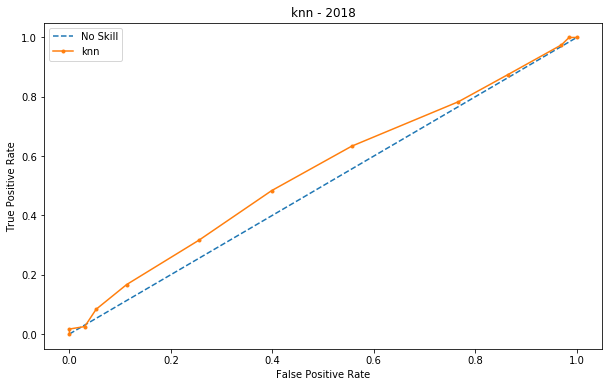

In [23]:
""" plotting ROC Curves"""
            
# Plotting an ROC curve to examine the predicitve capabilities of each algorithmn
# keep probabilities for the positive outcome only
y_predPOSONLY = grid_search.predict_proba(X_test)[:,1].astype(float)
            
#using this tells you which order the classes are in
grid_search.classes_
            
#generate a no skill model for comparison that always guesses 1 
ns_pred = [1 for _ in range(len(y_test))]

#Calculate ROC scores
ns_auc = roc_auc_score(y_test,ns_pred)
y_pred_auc = roc_auc_score(y_test,y_predPOSONLY)

# summarize ROC scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (y_pred_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
y_fpr, y_tpr, _ = roc_curve(y_test, y_predPOSONLY)
            
fig1b, ax = plt.subplots(figsize=(10,6))
# plot the roc curve for the model
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(y_fpr, y_tpr, marker='.', label='knn')
# axis labels
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
            
ax.set_title("{0} - {1}".format('knn',year))
# show the legend
ax.legend()
# show the plot
plt.show()

# 7 Analysing the investment performance of the trading algorithm.

We have seen the model has some predictive power in terms of predicting the dricetion of daily UK100 movements but how does that translate into investment performance. To decipher the investment performance we multiply the algorithmns predicted direction (1 or -1) by the actual return experienced that day.

What you can see if that for 2018 the algorithmn returns a cumulative return of 20% where as going long on the uk100 would have return -10%. This current does not include transaction costs however but is a stron indicator of performance capability.

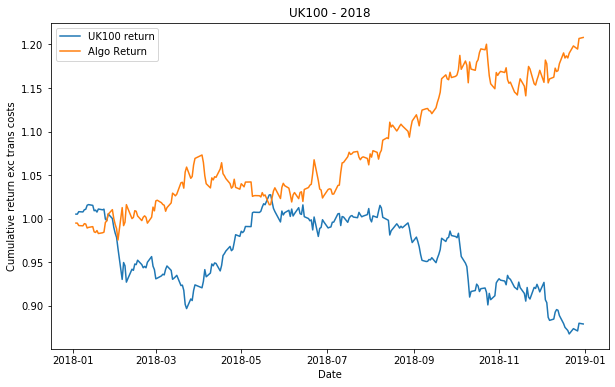

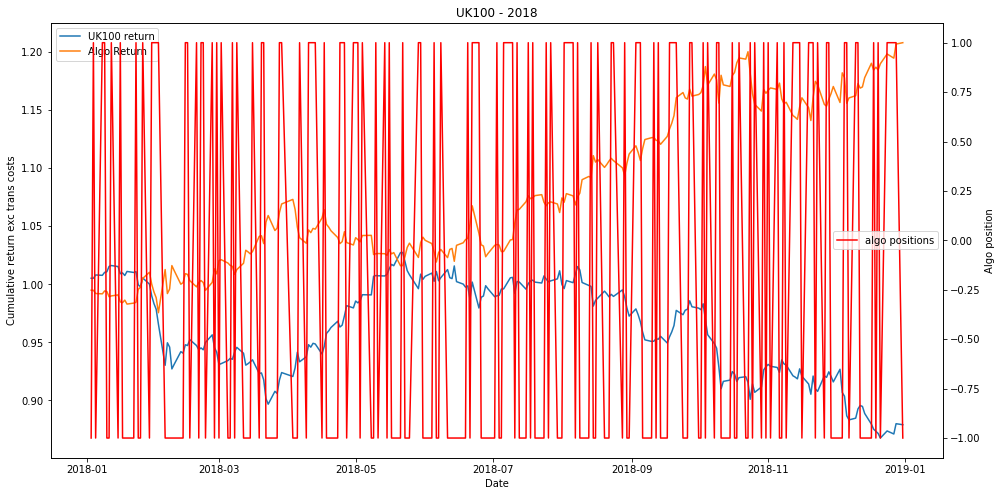

In [37]:
algo = pd.DataFrame(grid_search.predict(X_test), columns = ["algo_positions"])         
            
algo.set_index(X_test.index, inplace=True)

algo = pd.concat([algo,data], axis=1 )

algo["algo_pos_change_ind"] = algo["algo_positions"]*algo["algo_positions"].shift(1)                    

algo.dropna(inplace=True)

#set up a trade indicator """
algo["Trade_ind"] = np.where(algo['algo_pos_change_ind'] < 0 , 1, 0)

""" we establish the algo returns per day by mutliplying the prediction from the algo either long or short (1 or -1) by the actual return that day """ 
algo["algo_returns"] = algo.algo_positions * algo.returns

            
# plot the cumulative return of the algorithm versus the return of the index
fig2, ax = plt.subplots(figsize=(10,6))
ax.plot(algo["returns"].cumsum().apply(np.exp), label ='UK100 return')
ax.plot(algo["algo_returns"].cumsum().apply(np.exp), label ='Algo Return')
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return exc trans costs")
ax.set_title("{0} - {1}".format(index_totrade, year))

ax.legend(loc="upper left")
plt.show()
            
# plot the cumulative return of the algorithm versus the return of the index and the trading positions
fig3, ax = plt.subplots(figsize=(16,8))
ax_1 = ax.twinx()
ax.plot(algo["returns"].cumsum().apply(np.exp),label ='UK100 return')
ax.plot(algo["algo_returns"].cumsum().apply(np.exp), label ='Algo Return')
ax_1.plot(algo["algo_positions"],color='r', label='algo positions')
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return exc trans costs")
ax_1.set_ylabel("Algo position")
ax.set_title("{0} - {1}".format(index_totrade, year))
ax.legend()
ax_1.legend()
plt.show()

# 8 investing maximum drawdown and drawdown periods


In [1]:

# lets start with a theoretical 1000 pounds invested

Margin_amount = 1000
# showing how equity how the margin position would move
Margin_pos = (algo['return_inc_stoploss'].cumsum().apply(np.exp) * Margin_amount).astype(float)
    
Margin_pos = pd.DataFrame(Margin_pos.rename("Margin_pos", inplace=True))

#cumulative max returns the cumulative maximum values over time 
Margin_pos['cummax'] = Margin_pos.cummax()

# The drawdown values over time when the drawdon value is 0 that means we have reached a new high! the period between two zeros is the drawdown period""" 
Margin_pos["drawdown"] = Margin_pos['cummax']- Margin_pos['Margin_pos']
Margin_pos["drawdown_percent"] = Margin_pos["drawdown"]/Margin_pos['cummax']

# The maximum drawdown value
max_drawdown_percent = Margin_pos["drawdown_percent"].max()

# The point in time of the maximum drawdown, the idxmax returns the index of the position in this case a time stamp!!!
t_max= Margin_pos["drawdown_percent"].idxmax()
    
# The maximum drawdown percentage
max_drawdown_percentage = round(max_drawdown_percent*100,1)
# adding the maximum drawdown percentage to the results table
Prediction_ResultsByYear.loc[Y_year,(model_names[model_index],results_columns[17])] = max_drawdown_percentage
    
""" now we can plot the max drawdown and the drawdown periods """

# first we want to find the times of all the highs, when drawdown = 0 
high_indicies = Margin_pos["drawdown"][Margin_pos["drawdown"]==0]
# calculate the time delta between all te highs
dd_periods = (high_indicies.index[1:].to_pydatetime() - high_indicies.index[:-1].to_pydatetime())

# Sometimes the algorithmn may not make any positive return over the year period if that is the case we set the drawdown period to that of len 1year in buiness days
if len(high_indicies) == 1:
            
    max_dd_period = 250
                    
else:
        
    max_dd_period = dd_periods.max().days
    
            
#now we can plot the results
Margin_pos[['Margin_pos', 'cummax']].plot(figsize=(10,6))
#we can specifically add a line for t_max """
plt.axvline(t_max,c='r', alpha=0.5)

print('The maximum drawdown period for the algo in 2018 would have been: {}'.format(max_dd_period))

print('The maximum drawdown percentage for the algo in 2018 would have been: {}'.format(max_drawdown_percent))

NameError: name 'algo' is not defined